In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# %cd /content/drive/MyDrive/MASTERS/1st Semester/CAUSAL_INFERENCE_NEW/PROJECT/CNN_MODEL

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
event_data_og = pd.read_csv('processed_data/processed_events_final.csv', sep='|')
event_data_og = event_data_og.drop(columns=["TIMESTAMP_EVENT",'PAGE_SECTION','PAGE_SECTION_POSITION','DEVICE_INFO_BROWSER','TIME',
                                      'DEVICE_INFO_BRAND','DEVICE_INFO_TYPE','USER_SESSION_ID','DATE','purchases_30_day_after',
                                      'total_spend_on_category_product','total_spend_on_product','date'])

#Due to having na values
event_data_og = event_data_og.drop(columns=["PAGE_NAME","PRODUCT_TYPE","USER_PROMOTIONS_ALLOWED"])

#Due to too many unique values
# event_data = event_data.drop(columns=["PROPOSITION",'purchases_7_day_after']) #CAN REPLACE WITH USER CLUSTER IF YOU IMPLEMENT IT
event_data_og = event_data_og.drop(columns=['EVENT','PROPOSITION','USER_CLIENT_NUMBER'])

In [ ]:
event_data = event_data_og.sample(frac=.6, random_state=42)

In [ ]:
# All the column names that include "price"or "precip" in list format case insensitive
numeric_variables = [col for col in event_data.columns if any(substring.lower() in col.lower() for substring in ["price", "precip"])]

#All the collumns excpet the ones in numeric_variables and EVENT
categorical_variables = [col for col in event_data.columns if col not in numeric_variables]

['ARTICLE_CATEGORIE',
 'PROMOTION_LABEL',
 'USER_SALES_GROUP',
 'USER_SEGMENT',
 'USER_SALES_DISTRICT',
 'purchases_7_day_after',
 'temperature',
 'temperature_lead_1',
 'temperature_lead_2',
 'temperature_lead_3',
 'temperature_lead_4']

In [ ]:
# Split the column into multiple columns
split_columns = event_data['ARTICLE_CATEGORIE'].str.split(',', expand=True)

#Optionally, rename the columns for better readability
split_columns.columns = ['article_part1', 'article_part2', 'article_part3', 'article_part4']

#Create new collumns based on division
split_columns['article_part2'] = split_columns['article_part1'] + ',' + split_columns['article_part2']
split_columns['article_part3'] = split_columns['article_part2'] + ',' + split_columns['article_part3']
split_columns['article_part4'] = split_columns['article_part3'] + ',' + split_columns['article_part4']

# Concatenate the new columns back to the original DataFrame if needed
event_data = pd.concat([event_data, split_columns], axis=1)

#Drop the original 'ARTICLE_CATEGORIE' column
event_data.drop(['ARTICLE_CATEGORIE','article_part1'], axis=1,inplace=True)

In [ ]:
# Vectorized operations to create binary columns
event_data['purchased_7_days_after_binary'] = (event_data['purchases_7_day_after'] > 0).astype(int)
# event_data['purchased_30_days_after_binary'] = (event_data['purchases_30_day_after'] > 0).astype(int)

event_data.drop(columns=['purchases_7_day_after'],inplace=True)

In [ ]:
event_data['PROMOTION_PRICE'] = event_data['PROMOTION_PRICE'].fillna(event_data['PRICE'])

#Replace na values in PROMOTION_LABEL collumn with "No_Promotion"
event_data['PROMOTION_LABEL'] = event_data['PROMOTION_LABEL'].fillna("No_Promotion")

#Drop rows that has na values
event_data.dropna(inplace=True)

# All the column names that include "price"or "precip" in list format case insensitive
numeric_variables = [col for col in event_data.columns if any(substring.lower() in col.lower() for substring in ["price", "precip",'temperature'])]
numeric_variables

#All the collumns excpet the ones in numeric_variables and EVENT
categorical_variables = [col for col in event_data.columns if col not in numeric_variables and col != "EVENT"]
categorical_variables

target_variable = 'purchased_7_days_after_binary'

In [ ]:
tiny_transformed_event_df = event_data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

import torch
from torch import nn
from torch.utils.data import DataLoader

In [ ]:
# All the column names that include "price"or "precip" or "temperature" in list format case insensitive
numeric_variables = [col for col in event_data.columns if any(substring.lower() in col.lower() for substring in ["price", "precip","temperature"])]
numeric_variables

#All the collumns excpet the ones in numeric_variables and EVENT
nonnumeric_variables = [col for col in event_data.columns if ((col not in numeric_variables) & (col not in target_variable))]
nonnumeric_variables

#From te event_data create a dataset where it converts all nonnumeric_variables to dummies
tiny_transformed_event_df = pd.get_dummies(event_data, columns=nonnumeric_variables,dtype = int)

#From tiny_transformed_event_df select nonnumeric collumns names that doesn't have EVENT or numeric_variables in it
categorical_variables = [col for col in tiny_transformed_event_df.columns if((col not in numeric_variables) & (col not in target_variable))]
categorical_variables

#Select the collumns numeric_variables + categorical_variables from the data
independent_variables = tiny_transformed_event_df[numeric_variables + categorical_variables]

#Dependent Variable
dependent_variable = tiny_transformed_event_df[target_variable]

MemoryError: Unable to allocate 11.2 GiB for an array with shape (917, 3284229) and data type int32

In [ ]:
# # Normalize the numeric variables
# scaler = StandardScaler()
# tiny_transformed_event_df[numeric_variables] = scaler.fit_transform(tiny_transformed_event_df[numeric_variables])

# #Select the collumns numeric_variables + categorical_variables from the data
# tiny_transformed_event_df[numeric_variables] = tiny_transformed_event_df[numeric_variables]

In [ ]:
#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(independent_variables, dependent_variable, test_size=0.2, random_state=42)

#Convert to tensor type
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)

In [ ]:
'''
    Multilayer Perceptron
'''
class MLP(nn.Module):

    def __init__(self,n):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n, 1500),
            nn.ReLU(),
            nn.Linear(1500, 500),
            nn.ReLU(),
            nn.Linear(500, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

if __name__ == '__main__':
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'Using device: {device}')

    # Hyperparameters
    batch_size = 64
    learning_rate = 1e-4
    epochs = 5

    # Set fixed random seed
    torch.manual_seed(42)

    # Assume X_train and y_train are already defined and preprocessed

    # Create dataset and dataloader
    train_data = torch.utils.data.TensorDataset(X_train, y_train)
    trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # Initialize the network and move it to the device
    mlp = MLP(n=int(X_train.shape[1])).to(device)

    # Define loss function and optimizer
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        print('Epoch %s' % (epoch + 1))
        current_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)

            # Reshape targets to match the model output shape
            targets = targets.view(-1, 1)

            optimizer.zero_grad()
            outputs = mlp(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            current_loss += loss.item()

        print('Loss after epoch %5d: %.3f' % (epoch + 1, current_loss))

    print('Training finished!')

Using device: cuda
Epoch 1
Loss after epoch     1: 2167.986
Epoch 2
Loss after epoch     2: 2024.153
Epoch 3
Loss after epoch     3: 1975.676
Epoch 4
Loss after epoch     4: 1934.390
Epoch 5
Loss after epoch     5: 1890.510
Training finished!


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

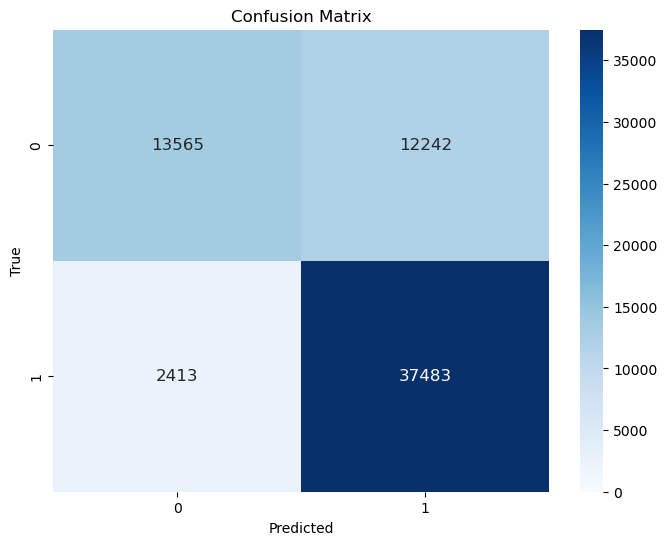

R^2 Score: 0.0648
MSE: 0.2230
MAE: 0.2230


In [ ]:
# Create a dataset for testing

batch_size = 64
#Convert to tensor type
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Create a dataset for testing
test_data = torch.utils.data.TensorDataset(X_test, y_test)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Switch to evaluation mode
mlp.eval()

# Generate predictions for the entire test set
all_predicted = []
all_targets = []

with torch.no_grad():
    for data in testloader:
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        outputs = mlp(inputs)
        predicted = (outputs > 0.5).float()  # For binary classification, apply threshold
        all_predicted.extend(predicted.cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

# Compute confusion matrix
conf_matrix = confusion_matrix(all_targets, all_predicted)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 12}, fmt="d", cmap="Blues",
            xticklabels=np.arange(conf_matrix.shape[1]), yticklabels=np.arange(conf_matrix.shape[0]),
            vmin=0, vmax=np.max(conf_matrix))  # Adjust vmin and vmax for better visibility of values
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print R^2, MSE, and MAE scores
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

r2 = r2_score(all_targets, all_predicted)
mse = mean_squared_error(all_targets, all_predicted)
mae = mean_absolute_error(all_targets, all_predicted)

print(f"R^2 Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

In [ ]:
# Generate classification report
report = classification_report(all_targets, all_predicted)

# Print the classification report
print(report)

              precision    recall  f1-score   support

         0.0       0.85      0.53      0.65     25807
         1.0       0.75      0.94      0.84     39896

    accuracy                           0.78     65703
   macro avg       0.80      0.73      0.74     65703
weighted avg       0.79      0.78      0.76     65703



In [ ]:
# Save the trained model
torch.save(mlp.state_dict(), 'trained_model.pth')
print('Trained model saved as "trained_model.pth"')

Trained model saved as "trained_model.pth"


In [ ]:
# Function to make predictions using the trained model
def predict(model, input_data, device):
    model.eval()  # Set the model to evaluation mode
    input_data = torch.tensor(input_data, dtype=torch.float32).to(device)
    with torch.no_grad():  # Disable gradient computation
        output = model(input_data)
    return output.cpu().numpy()

In [ ]:
X_train.shape

torch.Size([262809, 1099])

In [ ]:
class MLP(nn.Module):

    def __init__(self,n):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n, 1500),
            nn.ReLU(),
            nn.Linear(1500, 500),
            nn.ReLU(),
            nn.Linear(500, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)

class NN_MODEL:
    def __init__(self,batch_size=64, seed=42):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        self.seed = seed
        self.model = None  # Placeholder for the model

    def load(self, path='trained_model.pth'):
        # Load the model's state dictionary
        state_dict = torch.load(path, map_location=self.device)

        # Construct an instance of the model class
        self.model = MLP(n=1099)
        self.model.load_state_dict(state_dict)
        self.model.to(self.device)
        self.model.eval()  # Set the model to evaluation mode
        print('Model loaded!')

    def format(input_data):
        pass

    def predict(self, input_data):
        if self.model is None:
            print('Error: Model not loaded!')
            return

        input_data = torch.tensor(input_data, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            output = self.model(input_data)
        return output.cpu().numpy()

In [ ]:
test_model = NN_MODEL()
test_model.load()

Model loaded!
